# Relax Inc. Data Challenge

The data is available as two attached CSV files:
* takehome_user_engagement.csv
* takehome_users.csv

Defining an "adopted user" as a user who has logged into the product on three separate days 
in at least one seven-day period, identify which factors predict future user adoption.

In [61]:
import numpy as np
import pandas as pd
import datetime  
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(101)

%matplotlib inline

# Set plotting styles
sns.set_style('white') 

In [62]:
# Machine learning libraries:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [63]:
import warnings 
warnings.simplefilter('ignore')

In [64]:
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')

In [65]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [66]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [67]:
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [68]:
engagements = pd.read_csv('takehome_user_engagement.csv')

In [69]:
engagements.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [70]:
engagements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [71]:
engagements.time_stamp = pd.to_datetime(engagements.time_stamp)

In [72]:
engagements_2 = engagements.set_index('time_stamp').groupby('user_id')['visited'].resample('D').count()

In [73]:
engagements_2 = pd.DataFrame(engagements_2)

In [74]:
# engagements_2.isnull().sum()

In [75]:
engagements_2 = engagements_2.rolling(window=7, min_periods=1).sum()

In [76]:
engagements_2.reset_index(inplace=True)

In [77]:
engagements_2.head()

,user_id,time_stamp,visited
0,1,2014-04-22,1.0
1,2,2013-11-15,2.0
2,2,2013-11-16,2.0
3,2,2013-11-17,2.0
4,2,2013-11-18,2.0


In [78]:
engagements_3 = engagements_2.groupby('user_id')[['visited']].max()

In [79]:
engagements_3.head()

,visited
user_id,
1,1.0
2,3.0
3,2.0
4,3.0
5,4.0


In [80]:
# Add target column 'adopted'
engagements_3.loc[engagements_3['visited'] >= 3, 'adopted_user'] = 1
engagements_3.loc[engagements_3['visited'] < 3, 'adopted_user'] = 0

In [81]:
engagements_3['visited'] = engagements_3['visited'].astype(int)
engagements_3['adopted_user'] = engagements_3['adopted_user'].astype(int)

In [82]:
engagements_3.reset_index(inplace=True) 

In [83]:
engagements_3.head()

,user_id,visited,adopted_user
0,1,1,0
1,2,3,1
2,3,2,0
3,4,3,1
4,5,4,1


In [84]:
# DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, 
#                 right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

df = engagements_3.merge(users, how='inner', on='user_id', sort=True)

In [85]:
df.head(5)

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [86]:
df.isnull().sum()

user_id                          0
visited                          0
adopted_user                     0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
dtype: int64

In [87]:
df['invited_by_user_id'].fillna(0, inplace=True)
df['invited_by_user_id'] = df['invited_by_user_id'].astype(int)

In [88]:
# Do some feature engineering

df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time)
df['active_days'] = df['last_session_creation_time'] - df['creation_time']
df['active_days'] = df['active_days'].dt.days

In [89]:
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,-16183
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,-16025
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,-15784
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,-15847
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,-15723


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 13 columns):
user_id                       8823 non-null int64
visited                       8823 non-null int64
adopted_user                  8823 non-null int64
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
active_days                   8823 non-null int64
dtypes: datetime64[ns](2), int64(8), object(3)
memory usage: 1.3+ MB


In [91]:
df.isnull().sum()

user_id                       0
visited                       0
adopted_user                  0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
active_days                   0
dtype: int64

In [92]:
df.columns

Index(['user_id', 'visited', 'adopted_user', 'creation_time', 'name', 'email',
       'creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'active_days'],
      dtype='object')

In [93]:
# Select columns for machine learning algorithms
df_ml = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
              'org_id', 'invited_by_user_id', 'active_days', 'adopted_user' ]]

In [94]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 7 columns):
creation_source               8823 non-null object
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
active_days                   8823 non-null int64
adopted_user                  8823 non-null int64
dtypes: int64(6), object(1)
memory usage: 871.4+ KB


In [95]:
df_ml.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
0,GUEST_INVITE,1,0,11,10803,-16183,0
1,ORG_INVITE,0,0,1,316,-16025,1
2,ORG_INVITE,0,0,94,1525,-15784,0
3,GUEST_INVITE,0,0,1,5151,-15847,1
4,GUEST_INVITE,0,0,193,5240,-15723,1


In [96]:
df_ml.adopted_user.value_counts()

1    8015
0     808
Name: adopted_user, dtype: int64

In [97]:
df_ml_class1 = df_ml[df_ml['adopted_user']==1]
df_ml_class0 = df_ml[df_ml['adopted_user']==0]

In [98]:
# Randomly sample the same number of rows as dataframe df_ml_class0.
df_ml_class1_sampled = df_ml_class1.sample(n=len(df_ml_class0))

In [99]:
df_ml_class1_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808 entries, 538 to 4117
Data columns (total 7 columns):
creation_source               808 non-null object
opted_in_to_mailing_list      808 non-null int64
enabled_for_marketing_drip    808 non-null int64
org_id                        808 non-null int64
invited_by_user_id            808 non-null int64
active_days                   808 non-null int64
adopted_user                  808 non-null int64
dtypes: int64(6), object(1)
memory usage: 50.5+ KB


In [100]:
df_ml_balanced = df_ml_class1_sampled.append(df_ml_class0)

In [101]:
df_ml_balanced.adopted_user.value_counts()

1    808
0    808
Name: adopted_user, dtype: int64

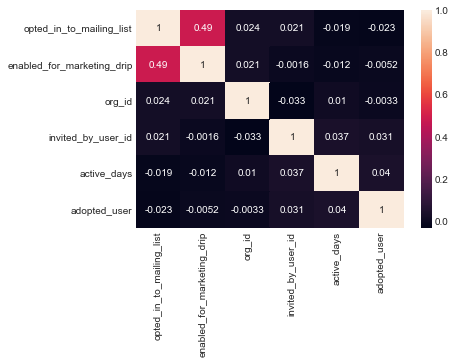

In [102]:
# Compute correlations for the columns of df_ml
corr = df_ml_balanced.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)

In [103]:
# Make dummy variables
creation_source_dum = pd.get_dummies(df_ml_balanced['creation_source'], drop_first=True)

In [104]:
df_ml_balanced.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
538,GUEST_INVITE,0,1,56,6965,-15919,1
1962,SIGNUP_GOOGLE_AUTH,0,0,51,0,-15981,1
8498,SIGNUP_GOOGLE_AUTH,0,0,121,0,-15904,1
4025,SIGNUP_GOOGLE_AUTH,1,1,2,0,-16096,1
4394,SIGNUP,1,0,178,0,-16092,1


In [105]:
df_ml_balanced.drop(['creation_source'], axis=1, inplace=True)

In [106]:
# Features
X = pd.concat([df_ml_balanced, creation_source_dum], axis=1)
X.drop(['adopted_user'], axis=1, inplace=True)
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
538,0,1,56,6965,-15919,0,0,0,0
1962,0,0,51,0,-15981,0,0,0,1
8498,0,0,121,0,-15904,0,0,0,1
4025,1,1,2,0,-16096,0,0,0,1
4394,1,0,178,0,-16092,0,0,1,0


In [107]:
# Target
y = df_ml_balanced['adopted_user']
y.head()

538     1
1962    1
8498    1
4025    1
4394    1
Name: adopted_user, dtype: int64

In [110]:
# Split the data into a train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [111]:
# Fit and models and make predictions
clf_RF = RandomForestClassifier(random_state=101, n_jobs = -1)
clf_RF.fit(X_train, y_train)
y_predicted_RF = clf_RF.predict(X_test)

clf_LR = LogisticRegression(random_state=101, n_jobs = -1)
clf_LR.fit(X_train, y_train)
y_predicted_LR = clf_LR.predict(X_test)

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
y_predicted_NB = clf_NB.predict(X_test)

In [112]:
# Classification tables

print("Random Forest:") 
print(classification_report(y_test, y_predicted_RF))
print('\n')

print("Logistic Regression:") 
print(classification_report(y_test, y_predicted_LR)) 
print('\n')

print("GaussianNB:") 
print(classification_report(y_test, y_predicted_NB)) 

Random Forest:
             precision    recall  f1-score   support

          0       0.53      0.57      0.55       248
          1       0.51      0.47      0.49       237

avg / total       0.52      0.52      0.52       485



Logistic Regression:
             precision    recall  f1-score   support

          0       0.51      0.60      0.55       248
          1       0.48      0.39      0.43       237

avg / total       0.49      0.49      0.49       485



GaussianNB:
             precision    recall  f1-score   support

          0       0.52      0.46      0.48       248
          1       0.49      0.55      0.52       237

avg / total       0.50      0.50      0.50       485



In [113]:
# Make a function to plot the ROC curve.
def roc_plot(clf, label):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf,_ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr_rf, tpr_rf, label = label)
    print(label + ": ", roc_auc_score(y_score = y_pred_proba, y_true = y_test))

Random Fordest:  0.502501020825
Logistic Regression:  0.51158636178
GaussianNB:  0.528481012658


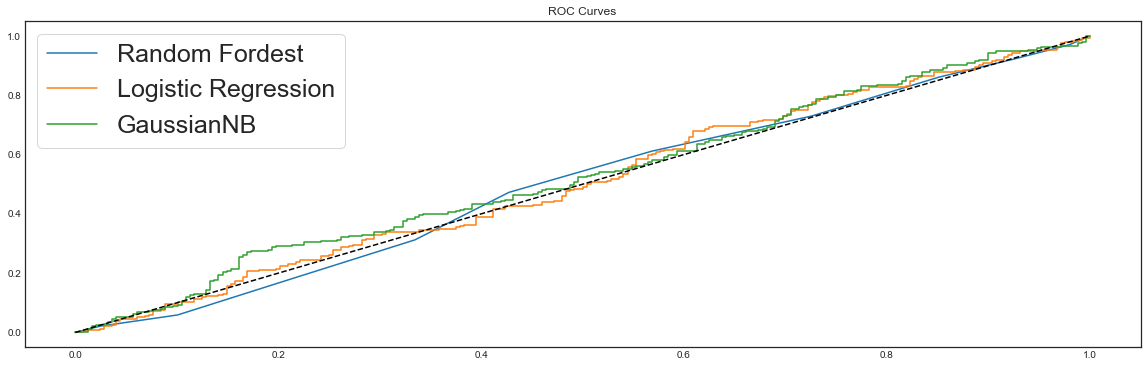

In [114]:
# Plot ROC Curves for all three models.
plt.figure(figsize = (20,6))
roc_plot(clf_RF, 'Random Fordest')
roc_plot(clf_LR, 'Logistic Regression')
roc_plot(clf_NB, 'GaussianNB')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.legend(loc='best', frameon=True, fontsize=25)

In [116]:
# Are all the features important for making the prediction?
# Use Random Forest to evaluate the importance of features on the classification task.
names = X.columns
rf = RandomForestClassifier()
rf.fit(X, y)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.37690000000000001, 'active_days'), (0.35160000000000002, 'org_id'), (0.1754, 'invited_by_user_id'), (0.028199999999999999, 'opted_in_to_mailing_list'), (0.0223, 'ORG_INVITE'), (0.018599999999999998, 'enabled_for_marketing_drip'), (0.0097000000000000003, 'SIGNUP'), (0.0088000000000000005, 'SIGNUP_GOOGLE_AUTH'), (0.0085000000000000006, 'PERSONAL_PROJECTS')]
